### Explicar o problema

In [167]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from sktime.forecasting.sarimax import SARIMAX
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from statsmodels.tsa.seasonal import STL
from sktime.forecasting.model_evaluation import evaluate
from sktime.split import ExpandingWindowSplitter
import itertools
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_absolute_percentage_error
import plotly.graph_objs as go
from sktime.split import temporal_train_test_split
from statsmodels.graphics.tsaplots import plot_acf

warnings.filterwarnings("ignore")



### Analise inicial

In [168]:
dataframe = pd.read_csv(
    'https://data.open-power-system-data.org/time_series/2020-10-06/time_series_60min_singleindex.csv')
dataframe['utc_timestamp'] = pd.to_datetime(dataframe['utc_timestamp'])
dataframe = dataframe.drop(index=0)
# Definir 'utc_timestamp' como índice
dataframe.set_index('utc_timestamp', inplace=True)

# Agrupar os dados para diário (somando a geração de energia por dia)
dataframe = dataframe.resample('M').sum()

dataframe

,cet_cest_timestamp,AT_load_actual_entsoe_transparency,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,BE_load_actual_entsoe_transparency,BE_load_forecast_entsoe_transparency,BE_solar_generation_actual,BE_wind_generation_actual,...,SI_load_actual_entsoe_transparency,SI_load_forecast_entsoe_transparency,SI_solar_generation_actual,SI_wind_onshore_generation_actual,SK_load_actual_entsoe_transparency,SK_load_forecast_entsoe_transparency,SK_solar_generation_actual,SK_wind_onshore_generation_actual,UA_load_actual_entsoe_transparency,UA_load_forecast_entsoe_transparency
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2015-01-31 00:00:00+00:00,2015-01-01T01:00:00+01002015-01-01T02:00:00+01...,5079048.0,5620098.0,20480.0,14256.0,549462.0,8389862.0,8252729.0,65221.24,581515.785,...,1120460.50,1111894.00,5808.19,182.36,2555672.0,2572260.0,10921.15,0.00,0.0,0.0
2015-02-28 00:00:00+00:00,2015-02-01T01:00:00+01002015-02-01T02:00:00+01...,5278559.0,5237253.0,26111.0,32851.0,459886.0,7625899.0,7539963.0,131034.59,391877.385,...,1032598.92,1044634.00,11546.56,759.53,2362171.5,2375760.0,28920.35,0.00,0.0,0.0
2015-03-31 00:00:00+00:00,2015-03-01T01:00:00+01002015-03-01T02:00:00+01...,5461849.0,5505595.0,23031.0,63640.0,522998.0,7977966.0,7879911.0,233875.00,463987.615,...,1049522.85,1048998.79,25373.44,576.50,2492045.5,2503050.0,48649.00,0.00,0.0,0.0
2015-04-30 00:00:00+00:00,2015-04-01T02:00:00+02002015-04-01T03:00:00+02...,4845043.0,4860424.0,21915.0,91787.0,529650.0,7255142.0,7231763.0,393257.30,287054.275,...,943489.33,951406.00,29728.31,337.97,2260582.4,2277200.0,65133.60,0.00,0.0,0.0
2015-05-31 00:00:00+00:00,2015-05-01T02:00:00+02002015-05-01T03:00:00+02...,4456141.0,4597204.0,18740.0,97773.0,409035.0,7075646.0,7015612.0,413897.44,370310.250,...,977345.53,969716.00,26039.69,217.62,2247499.4,2249730.0,60594.45,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-31 00:00:00+00:00,2020-05-01T02:00:00+02002020-05-01T03:00:00+02...,4535770.0,4346994.0,0.0,202893.0,719398.0,6268040.0,6210957.0,683333.07,651581.955,...,904882.22,906060.00,29872.51,476.31,2082104.0,2089180.0,61800.20,292.10,10323071.0,10820610.0
2020-06-30 00:00:00+00:00,2020-06-01T02:00:00+02002020-06-01T03:00:00+02...,4507322.0,4314150.0,0.0,193651.0,658390.0,6297759.0,6083761.0,577627.26,535880.200,...,919896.16,920242.00,27830.75,175.83,2088559.1,2080090.0,55267.35,379.45,10249848.0,10692550.0
2020-07-31 00:00:00+00:00,2020-07-01T02:00:00+02002020-07-01T03:00:00+02...,4796414.0,4589524.0,0.0,138302.0,361385.0,6320078.0,6393801.0,547617.46,562672.160,...,971105.51,970804.00,36467.38,309.59,2180159.6,2181520.0,65630.70,168.90,10932616.0,11398190.0


### Escolha de um pais para realizar o forecast

In [169]:
dataframe = dataframe.filter(regex="^FR")

dataframe.index = dataframe.index.date
dataframe.index = pd.to_datetime(dataframe.index)
dataframe

,FR_load_actual_entsoe_transparency,FR_load_forecast_entsoe_transparency,FR_solar_generation_actual,FR_wind_onshore_generation_actual
2015-01-31,51654270.0,51724250.0,243022.0,2093448.0
2015-02-28,47963647.0,48053900.0,349087.0,1722133.0
2015-03-31,45108903.0,45079917.0,522988.0,1814341.0
2015-04-30,36438366.0,36514700.0,740152.0,1351669.0
2015-05-31,33639147.0,33599793.5,797195.0,1498074.5
...,...,...,...,...
2020-05-31,30464502.0,30483250.0,1548259.0,2591893.0
2020-06-30,30391564.5,30431900.0,1384989.5,2015405.0
2020-07-31,32828106.0,32658950.0,1666921.0,2078603.0
2020-08-31,31003446.0,31128650.0,1482768.0,1998967.0


In [170]:
dataframe.describe()

,FR_load_actual_entsoe_transparency,FR_load_forecast_entsoe_transparency,FR_solar_generation_actual,FR_wind_onshore_generation_actual
count,6.900000e+01,6.900000e+01,6.900000e+01,6.900000e+01
mean,3.886228e+07,3.895800e+07,8.099831e+05,2.150907e+06
std,6.905116e+06,6.982785e+06,3.771850e+05,9.169105e+05
min,3.039156e+07,3.043190e+07,2.430220e+05,9.720360e+05
25%,3.301500e+07,3.303025e+07,4.403840e+05,1.450821e+06
50%,3.641101e+07,3.630200e+07,7.746720e+05,2.015405e+06
75%,4.400320e+07,4.415350e+07,1.057670e+06,2.561219e+06
max,5.697285e+07,5.750020e+07,1.666921e+06,5.563173e+06


In [171]:
dataframe.isna().sum()

FR_load_actual_entsoe_transparency      0
FR_load_forecast_entsoe_transparency    0
FR_solar_generation_actual              0
FR_wind_onshore_generation_actual       0
dtype: int64

In [172]:
dataframe.fillna(0, inplace=True)

### Plots serie de energia eolica

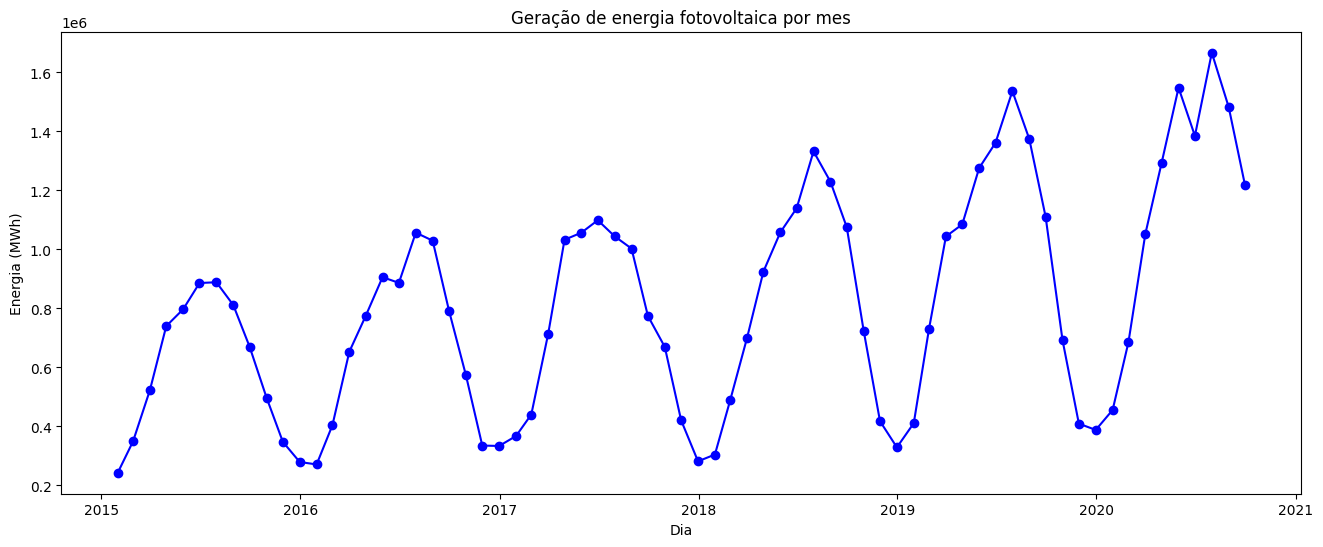

In [173]:
plt.figure(figsize=(16, 6))

plt.plot(dataframe.index, dataframe['FR_solar_generation_actual'], marker='o', linestyle='-', color='b')

# Títulos e rótulos dos eixos
plt.title('Geração de energia fotovoltaica por mes')
plt.xlabel('Dia')
plt.ylabel('Energia (MWh)')

# Mostrar o gráfico
plt.show()

In [174]:
stl = STL(dataframe['FR_solar_generation_actual'], seasonal=13)
result = stl.fit()

In [175]:
observed = result.observed
trend = result.trend
seasonal = result.seasonal
resid = result.resid

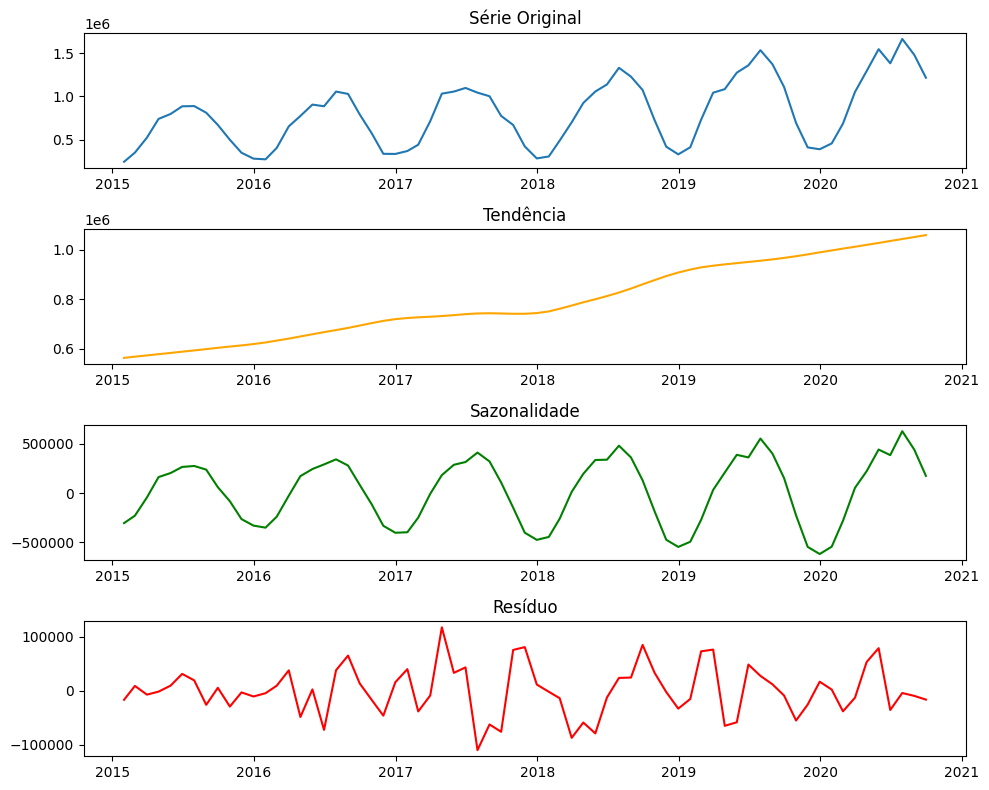

In [176]:
fig, axs = plt.subplots(4, 1, figsize=(10, 8))

# Gráfico da série original
axs[0].plot(dataframe.index, observed, label='Série Original')
axs[0].set_title('Série Original')

# Gráfico da tendência
axs[1].plot(dataframe.index, trend, label='Tendência', color='orange')
axs[1].set_title('Tendência')

# Gráfico da sazonalidade
axs[2].plot(dataframe.index, seasonal, label='Sazonalidade', color='green')
axs[2].set_title('Sazonalidade')

# Gráfico do resíduo
axs[3].plot(dataframe.index, resid, label='Resíduo', color='red')
axs[3].set_title('Resíduo')

# Ajustar o layout
plt.tight_layout()

# Mostrar o gráfico
plt.show()

### Explica

### PACF e ACF

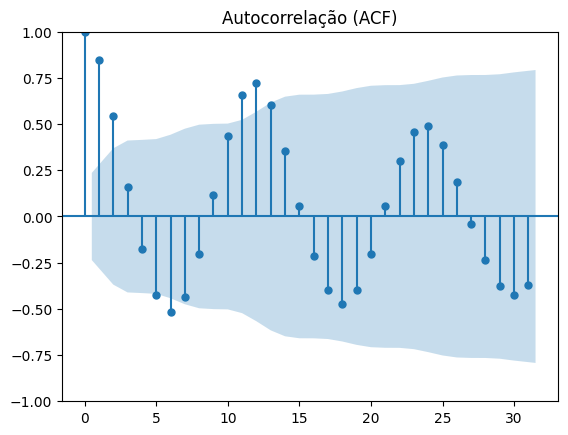

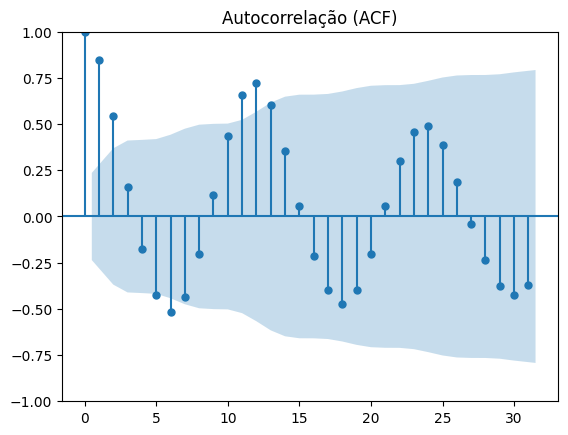

In [177]:
plot_acf(dataframe['FR_solar_generation_actual'], lags=31, ax=plt.gca(), title='Autocorrelação (ACF)')

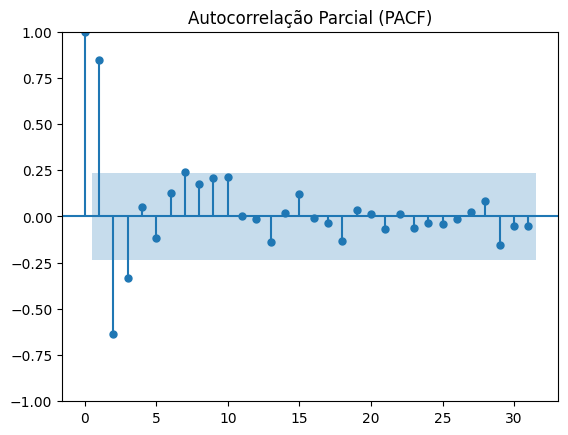

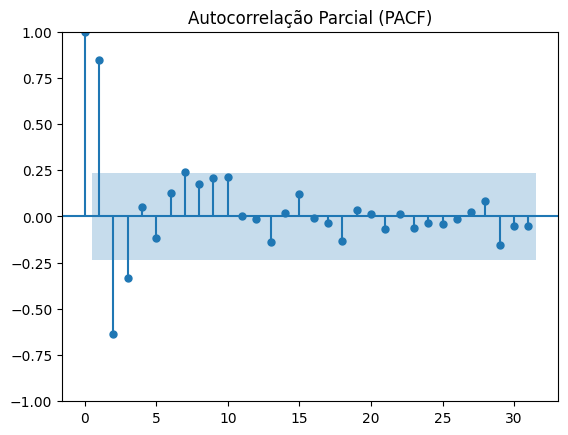

In [178]:
plot_pacf(dataframe['FR_solar_generation_actual'], lags=31, title='Autocorrelação Parcial (PACF)')

### Forecast com SARIMA

In [179]:
dataframe = dataframe[dataframe.index < '2020-01-01']

In [180]:
p = q = range(0, 3)
d= D = range(0, 2)
P = Q = range(0, 3)
s = [12]

param_arima = list(itertools.product(p, d, q))
param_seasonal = list(itertools.product(P, D, Q, s))

In [181]:
dataframe.index = dataframe.index.to_period('M')
y_train, y_test = temporal_train_test_split(dataframe['FR_solar_generation_actual'], test_size=12)

In [182]:
cv = ExpandingWindowSplitter(fh=list(range(1,13)), initial_window=12, step_length=12)

In [183]:
evaluate_list = []

for order in param_arima:
    for seasonal_order in param_seasonal:
        forecaster = SARIMAX(order=order, seasonal_order=seasonal_order)
        results = evaluate(forecaster=forecaster, cv=cv, y=y_train, scoring=[MeanAbsolutePercentageError()],
                           return_data=True)
        results['order'] = [order] * len(results)
        results['seasonal'] = [seasonal_order] * len(results)
        evaluate_list.append(results)

df_results = pd.concat(evaluate_list, ignore_index=True)

In [184]:
df_results

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred,order,seasonal
0,0.442760,0.009374,0.005640,12,2015-12,2015-01 243022.0 2015-02 349087.0 2015-0...,2016-01 271168.0 2016-02 404158.0 2016...,2016-01 586168.041667 2016-02 586168.041...,"(0, 0, 0)","(0, 0, 0, 12)"
1,0.435449,0.009722,0.005444,24,2016-12,2015-01 243022.0 2015-02 349087.0 2015...,2017-01 367533.0 2017-02 440384.0 2017...,2017-01 627119.208333 2017-02 627119.208...,"(0, 0, 0)","(0, 0, 0, 12)"
2,0.475157,0.009256,0.005311,36,2017-12,2015-01 243022.0 2015-02 349087.0 2015...,2018-01 304627.0 2018-02 488424.0 2018...,2018-01 665433.083333 2018-02 665433.083...,"(0, 0, 0)","(0, 0, 0, 12)"
3,0.442760,0.014782,0.005487,12,2015-12,2015-01 243022.0 2015-02 349087.0 2015-0...,2016-01 271168.0 2016-02 404158.0 2016...,2016-01 586168.041667 2016-02 586168.041...,"(0, 0, 0)","(0, 0, 1, 12)"
4,0.307322,0.035164,0.005942,24,2016-12,2015-01 243022.0 2015-02 349087.0 2015...,2017-01 367533.0 2017-02 440384.0 2017...,2017-01 528855.536607 2017-02 573272.045...,"(0, 0, 0)","(0, 0, 1, 12)"
...,...,...,...,...,...,...,...,...,...,...
967,0.980369,3.602171,0.007348,24,2016-12,2015-01 243022.0 2015-02 349087.0 2015...,2017-01 367533.0 2017-02 440384.0 2017...,2017-01 262357.504697 2017-02 285650.790...,"(2, 1, 2)","(2, 1, 1, 12)"
968,0.352987,2.105803,0.006794,36,2017-12,2015-01 243022.0 2015-02 349087.0 2015...,2018-01 304627.0 2018-02 488424.0 2018...,2018-01 259786.297065 2018-02 334892.332...,"(2, 1, 2)","(2, 1, 1, 12)"
969,0.186642,0.033766,0.007224,12,2015-12,2015-01 243022.0 2015-02 349087.0 2015-0...,2016-01 271168.0 2016-02 404158.0 2016...,2016-01 4.007881e+05 2016-02 5.068531e+0...,"(2, 1, 2)","(2, 1, 2, 12)"
970,0.902865,1.610745,0.007040,24,2016-12,2015-01 243022.0 2015-02 349087.0 2015...,2017-01 367533.0 2017-02 440384.0 2017...,2017-01 306931.928725 2017-02 334140.591...,"(2, 1, 2)","(2, 1, 2, 12)"


In [185]:
comb_to_drop = df_results[df_results.isna().any(axis=1)][['order', 'seasonal']].drop_duplicates()
comb_to_drop

,order,seasonal
9,"(0, 0, 0)","(0, 1, 0, 12)"
12,"(0, 0, 0)","(0, 1, 1, 12)"
15,"(0, 0, 0)","(0, 1, 2, 12)"
27,"(0, 0, 0)","(1, 1, 0, 12)"
30,"(0, 0, 0)","(1, 1, 1, 12)"
33,"(0, 0, 0)","(1, 1, 2, 12)"
45,"(0, 0, 0)","(2, 1, 0, 12)"
48,"(0, 0, 0)","(2, 1, 1, 12)"
51,"(0, 0, 0)","(2, 1, 2, 12)"
171,"(0, 1, 0)","(0, 1, 0, 12)"


In [197]:
df_filtered = df_results.merge(comb_to_drop, on=['order', 'seasonal'], how='left', indicator=True)
df_filtered = df_filtered[df_filtered['_merge'] == 'left_only'].drop(columns=['_merge'])

In [198]:
best_validate_mape = df_filtered.groupby(['seasonal', 'order'])['test_MeanAbsolutePercentageError'].mean().reset_index()

In [199]:
best_validate_mape = best_validate_mape.nsmallest(1, 'test_MeanAbsolutePercentageError')
best_validate_mape

,seasonal,order,test_MeanAbsolutePercentageError
247,"(2, 1, 1, 12)","(0, 0, 2)",0.117383


In [201]:
df_results[(df_results['order'] == (0, 0, 2)) & (df_results['seasonal'] == (2, 1, 1, 12))]

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred,order,seasonal
156,0.121797,0.027170,0.006578,12,2015-12,2015-01 243022.0 2015-02 349087.0 2015-0...,2016-01 271168.0 2016-02 404158.0 2016...,2016-01 243022.0 2016-02 349087.0 2016-0...,"(0, 0, 2)","(2, 1, 1, 12)"
157,0.116279,0.833049,0.006261,24,2016-12,2015-01 243022.0 2015-02 349087.0 2015...,2017-01 367533.0 2017-02 440384.0 2017...,2017-01 3.230040e+05 2017-02 4.470269e+0...,"(0, 0, 2)","(2, 1, 1, 12)"
158,0.114074,0.712065,0.005617,36,2017-12,2015-01 243022.0 2015-02 349087.0 2015...,2018-01 304627.0 2018-02 488424.0 2018...,2018-01 3.926487e+05 2018-02 4.829692e+0...,"(0, 0, 2)","(2, 1, 1, 12)"


In [202]:
df_valid = pd.concat([df_results.iloc[i,7] for i in range(3)])
df_valid

2016-01    586168.041667
2016-02    586168.041667
2016-03    586168.041667
2016-04    586168.041667
2016-05    586168.041667
2016-06    586168.041667
2016-07    586168.041667
2016-08    586168.041667
2016-09    586168.041667
2016-10    586168.041667
2016-11    586168.041667
2016-12    586168.041667
2017-01    627119.208333
2017-02    627119.208333
2017-03    627119.208333
2017-04    627119.208333
2017-05    627119.208333
2017-06    627119.208333
2017-07    627119.208333
2017-08    627119.208333
2017-09    627119.208333
2017-10    627119.208333
2017-11    627119.208333
2017-12    627119.208333
2018-01    665433.083333
2018-02    665433.083333
2018-03    665433.083333
2018-04    665433.083333
2018-05    665433.083333
2018-06    665433.083333
2018-07    665433.083333
2018-08    665433.083333
2018-09    665433.083333
2018-10    665433.083333
2018-11    665433.083333
2018-12    665433.083333
Freq: M, Name: FR_solar_generation_actual, dtype: float64

In [203]:
best_order = (0, 0, 2)
best_seasonal = (2, 1, 1, 12)

In [204]:
forecaster = SARIMAX(order=best_order, seasonal_order=best_seasonal)
y_pred = forecaster.fit(y_train).predict(list(range(1, 13)))
y_pred

2019-01    3.907204e+05
2019-02    5.930532e+05
2019-03    7.923347e+05
2019-04    1.034330e+06
2019-05    1.152805e+06
2019-06    1.232021e+06
2019-07    1.392580e+06
2019-08    1.295958e+06
2019-09    1.132573e+06
2019-10    8.106179e+05
2019-11    5.074527e+05
2019-12    4.085965e+05
Freq: M, Name: FR_solar_generation_actual, dtype: float64

In [205]:
y_test

2019-01     411067.0
2019-02     731057.0
2019-03    1043998.0
2019-04    1085006.0
2019-05    1275950.0
2019-06    1361439.0
2019-07    1536785.0
2019-08    1374409.0
2019-09    1110578.0
2019-10     692685.0
2019-11     409403.0
2019-12     388092.0
Freq: M, Name: FR_solar_generation_actual, dtype: float64

In [206]:
print(f'MAPE de teste: {mean_absolute_percentage_error(y_pred, y_test)}')

MAPE de teste: 0.11963790370884549


In [207]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=dataframe.index.to_timestamp(), y=dataframe['FR_solar_generation_actual'], mode='lines+markers',
               name='Dados reais'))
fig.add_trace(go.Scatter(x=df_valid.index.to_timestamp(), y=df_valid, mode='lines+markers', name='Previsão'))

fig.add_trace(go.Scatter(x=y_pred.index.to_timestamp(), y=y_pred, mode='lines+markers', name='Previsão'))
fig.update_layout(
    title='Gráfico de Múltiplas Linhas',
    xaxis_title='Eixo X',
    yaxis_title='Eixo Y',
    legend_title='Linhas',
    template='plotly'
)

# Exibir o gráfico
fig.show()

In [208]:
forecaster.update(dataframe['FR_solar_generation_actual'])

SARIMAX(order=(0, 0, 2), seasonal_order=(2, 1, 1, 12))

In [210]:
y_pred = forecaster.predict(list(range(1, 13)))

In [211]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=dataframe.index.to_timestamp(), y=dataframe['FR_solar_generation_actual'], mode='lines+markers',name='Dados reais'))
fig.add_trace(go.Scatter(x=y_pred.index.to_timestamp(), y=y_pred, mode='lines+markers', name='Previsão'))
fig.update_layout(
    title='Gráfico de Múltiplas Linhas',
    xaxis_title='Eixo X',
    yaxis_title='Eixo Y',
    legend_title='Linhas',
    template='plotly'
)

# Exibir o gráfico
fig.show()